# Question


1. Evaluate the performance of your models using appropriate evaluation metrics (e.g., accuracy, precision, recall).
2. Compare the performance of your fine-tuned models with the original pretrained models and discuss any improvements or challenges encountered during the fine-tuning process.

## Libraries

In [1]:
#import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## **1. Data Preprocessing**
### Step 1: Data Importation

In [2]:
#define URL
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

#define batch size
BATCH_SIZE = 32
#define image size
IMG_SIZE = (160, 160)

68606236/68606236 [==============================] - 1s 0us/step


### Step 2: Define Training, Validation and Testing sets

In [3]:
#define training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
#define validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


We can view the first 9 images and their associated labels in the dataset as follows:

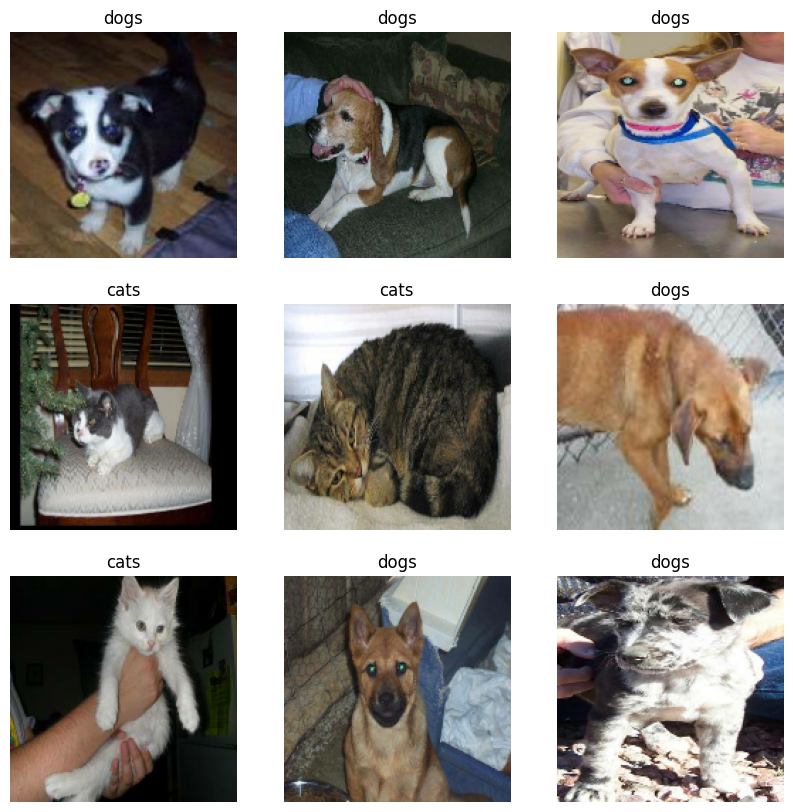

In [5]:
#visualise first nine elements
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We then create a test set from the validation set as follows:

In [6]:
#compute the number of elements in the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

#create a test dataset with a 5th of the validation dataset
test_dataset = validation_dataset.take(val_batches // 5)

#exclude the test dataset from the validation dataset
validation_dataset = validation_dataset.skip(val_batches // 5)

#print the number of test and validation batches to check for success
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Step 3: Configure dataset for performance

In [7]:
#allows TensorFlow to automatically determine the optimal value for various parameters
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Step 4: Data Augmentation

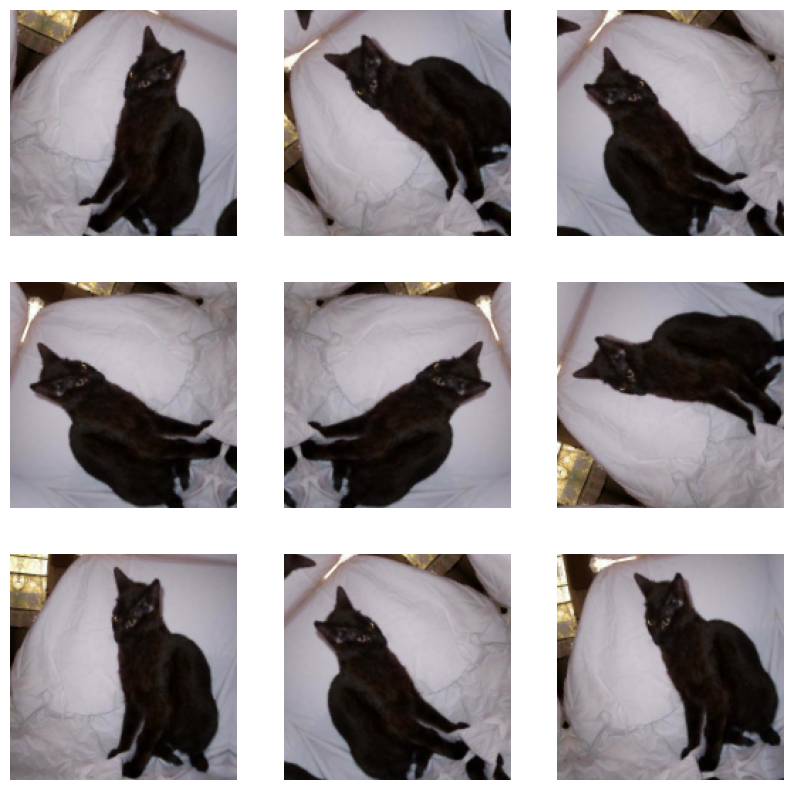

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

#Plot the result on one image
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Step 5: Rescale Pixel values

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## 2. **Creation of model from pretrained convnets**

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
#feature extractor to transform the images into higher level representations of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:
#freeze the convolutional base
base_model.trainable = False

#take a look at the model
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [13]:
#add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
#convert these features into a single prediction
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [15]:
#build the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

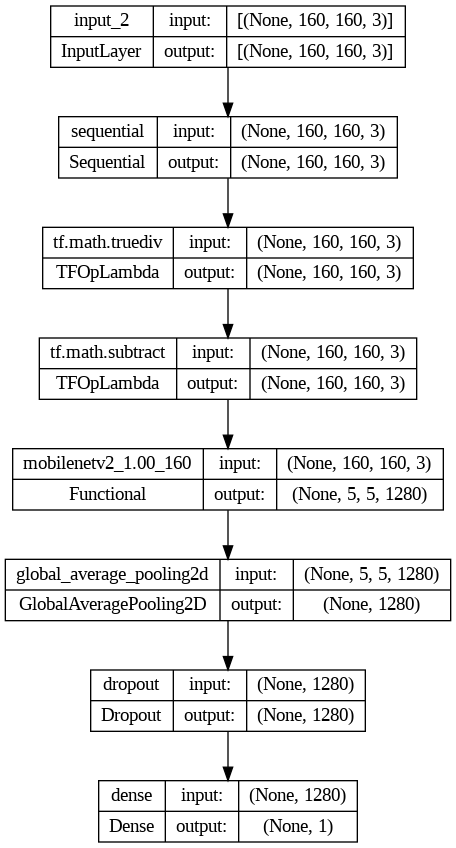

In [16]:
#plot a representation of the model
tf.keras.utils.plot_model(model, show_shapes=True)

## 3. **Compile and Train the model**

In [17]:
#compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [18]:
#train the model for 10 epochs
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 69s 928ms/step - loss: 0.7166 - accuracy: 0.5795 - val_loss: 0.5163 - val_accuracy: 0.7797
Epoch 2/10
63/63 [==============================] - 61s 969ms/step - loss: 0.5282 - accuracy: 0.7425 - val_loss: 0.3745 - val_accuracy: 0.8762
Epoch 3/10
63/63 [==============================] - 68s 1s/step - loss: 0.4330 - accuracy: 0.8080 - val_loss: 0.2806 - val_accuracy: 0.9406
Epoch 4/10
63/63 [==============================] - 70s 1s/step - loss: 0.3635 - accuracy: 0.8530 - val_loss: 0.2299 - val_accuracy: 0.9480
Epoch 5/10
63/63 [==============================] - 74s 1s/step - loss: 0.3006 - accuracy: 0.8920 - val_loss: 0.2020 - val_accuracy: 0.9554
Epoch 6/10
63/63 [==============================] - 64s 1s/step - loss: 0.2801 - accuracy: 0.9000 - val_loss: 0.1723 - val_accuracy: 0.9653
Epoch 7/10
63/63 [==============================] - 70s 1s/step - loss: 0.2579 - accuracy: 0.9045 - val_loss: 0.1548 - val_accuracy: 0.9678
Epoch 8/10
63/

## 4. **Evaluation of Performance**

### Learning Curves

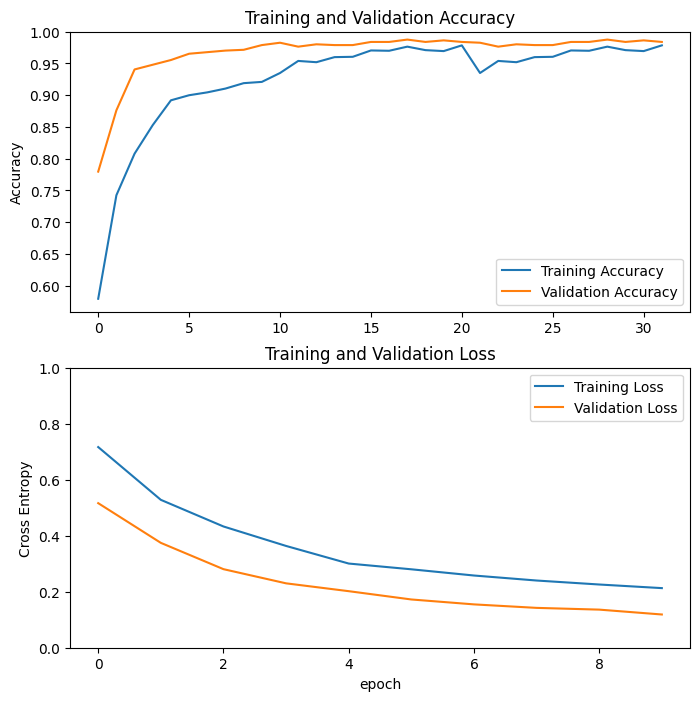

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 5s 764ms/step - loss: 0.1086 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


### Predictions

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0]


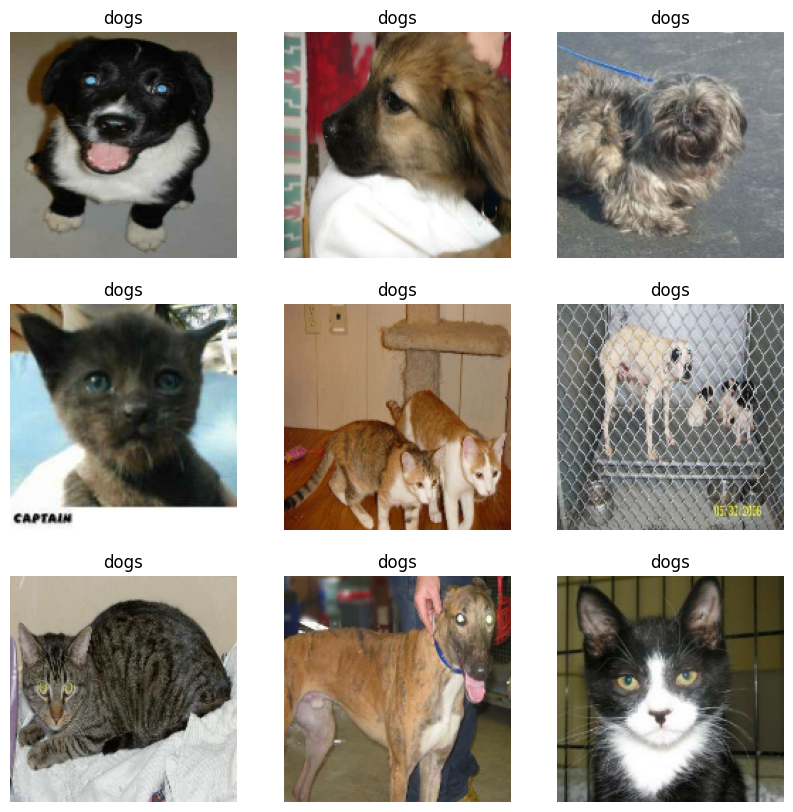

In [21]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Using the Actual labels and the predicted values, we can calculate the accuracy, precision and recall of the model.

In [22]:
#define the prediced and actual labels
predicted_labels = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
actual_labels = np.array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1])

#import the necessary functions from sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score


#### 1. Accuracy
Accuracy measures the proportion of true results (both true positives and true negatives) among the total number of cases examined.
Mathematically, it is calculated as:
$$Accuracy = \frac{TP +TN}{TP + TN + FP + FN}  $$
Where:
- TP - number of true positives
- TN - number of true negatives
- FP - number of false positives
- FN - number of false negatives

In python, we can use the `accuracy_score` function

In [23]:
# Accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

#print
print("Accuracy:", accuracy)

Accuracy: 0.65625


The computed accuracy score shows that the model predicts a label correctly, whether positive or negative, $65.625\%$ of the time.

#### 2. Precision


Precision measures the accuracy of positive predictions.

Mathematically, it is calculated as:
$$ Precision = \frac{TP}{TP + FP}$$

Where:
- TP - number of true positives
- FP - number of false positives

In python, we can use the `precision_score` function

In [24]:
# Precision
precision = precision_score(actual_labels, predicted_labels)

#print
print("Precision:", precision)

Precision: 0.65625


The computed precision score shows that the model predicts true positives $65.625\%$ of the time.

#### 3. Recall
Recall, also known as sensitivity or true positive rate (TPR), measures the ability of the classifier to find all the positive samples.

Mathematically, it is calculated as:
$$ Recall = \frac{TP}{TP+FN}$$

Where:
- TP - number of true positives
- FN - number of false negatives

In python, we can use the `recall_score` function.

In [25]:
# Recall
recall = recall_score(actual_labels, predicted_labels)

#print
print("Recall:", recall)

Recall: 1.0


The computed precision score shows that the model finds all the positive labels $100\%$ of the time.

#### Overall Interpretation
The models recall score is at $100\%$ as it is biased towards **only predicting positive outcomes**. This could be due to the prevalence of positive outcomes (dogs) int he training dataset as opposed to cats.

The Accuracy and Precision scores are the same, as there are no true negatives or false negatives predicted, cancelling them out from the accuracy formula.

## 4. Create a Fine Tuned Model

### 1. Unfreeze the top layers of the model

In [26]:
#unfreeze model
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  154


In [27]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### 2. Compile the model

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### 3. Train the model further


In [29]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 139s 2s/step - loss: 0.1592 - accuracy: 0.9350 - val_loss: 0.0588 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 123s 2s/step - loss: 0.1095 - accuracy: 0.9540 - val_loss: 0.0558 - val_accuracy: 0.9765
Epoch 12/20
63/63 [==============================] - 124s 2s/step - loss: 0.1152 - accuracy: 0.9520 - val_loss: 0.0488 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 87s 1s/step - loss: 0.0996 - accuracy: 0.9600 - val_loss: 0.0456 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 83s 1s/step - loss: 0.1012 - accuracy: 0.9605 - val_loss: 0.0488 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 76s 1s/step - loss: 0.0750 - accuracy: 0.9705 - val_loss: 0.0403 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 80s 1s/step - loss: 0.0806 - accuracy: 0.9700 - val_loss: 0.0409 - val_accuracy: 0.9839
Epoch 17/2

## **5. Evaluation of the fine Tuned model**

### 1. Learning curves

In [35]:
print(loss)
print(acc)

[0.71661376953125, 0.5281566381454468, 0.4330351948738098, 0.36347976326942444, 0.3006252944469452, 0.28008005023002625, 0.2578815221786499, 0.2399953156709671, 0.2257792055606842, 0.21287387609481812]
[0.5795000195503235, 0.7425000071525574, 0.8080000281333923, 0.8529999852180481, 0.8920000195503235, 0.8999999761581421, 0.9045000076293945, 0.9104999899864197, 0.9190000295639038, 0.9210000038146973, 0.9350000023841858, 0.9539999961853027, 0.9520000219345093, 0.9599999785423279, 0.9605000019073486, 0.9704999923706055, 0.9700000286102295, 0.9764999747276306, 0.9710000157356262, 0.9695000052452087, 0.9785000085830688, 0.9350000023841858, 0.9539999961853027, 0.9520000219345093, 0.9599999785423279, 0.9605000019073486, 0.9704999923706055, 0.9700000286102295, 0.9764999747276306, 0.9710000157356262, 0.9695000052452087, 0.9785000085830688]


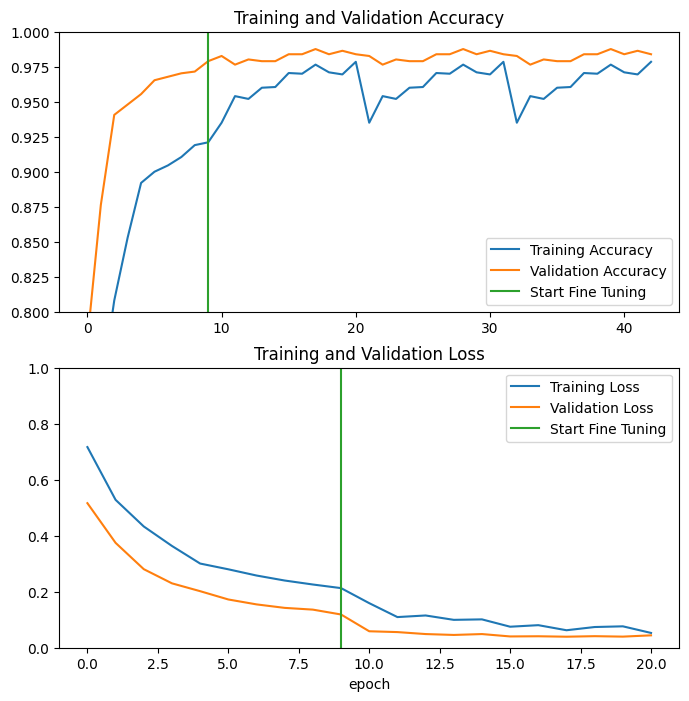

In [36]:
#update accuracy and loss values
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

#plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 2. Predictive Accuracy, Precsion and Recall

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1]


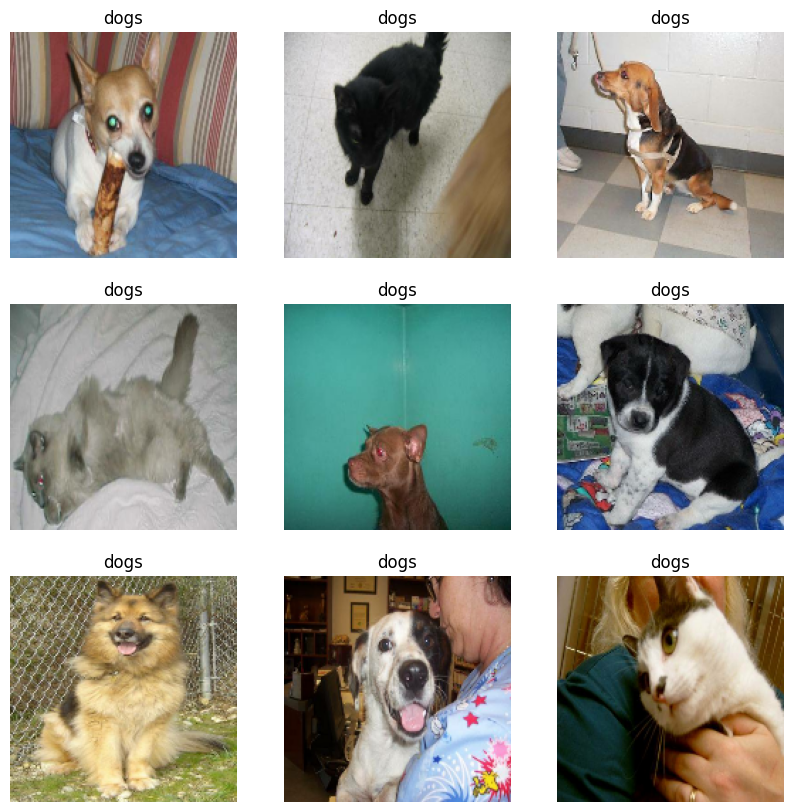

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [38]:
#define predicted and actual labels
predicted_2 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

actual_2 = np.array([1, 0, 1, 0, 1, 1, 1, 1 ,0, 0, 0, 1, 1, 1, 1, 1,0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1])

#### 1. Accuracy

In [39]:
# Accuracy
accuracy_fine = accuracy_score(actual_2, predicted_2)

#print
print("Accuracy:", accuracy_fine)

Accuracy: 0.6875


The computed accuracy score shows that the model predicts a label correctly, whether positive or negative, $68.75\%$ of the time.

#### 4. Precision

In [40]:
# Precision
precision_fine = precision_score(actual_2, predicted_2)

#print
print("Precision:", precision_fine)

Precision: 0.6875


The computed precision score shows that the model predicts true positives 68.75\%$ of the time.

#### 3. Recall

In [41]:
# Recall
recall_fine = recall_score(actual_2, predicted_2)

#print
print("Recall:", recall_fine)

Recall: 1.0


The computed precision score shows that the model finds all the positive labels $100\%$ of the time.

## **6. Comparison of Initial and Fine Tuned Models**

In [42]:
0.6875 - 0.65625


0.03125

The fine tuned model performs $3.1\%$ better than the original model.